### PAR-2 RING SEC-MALS (Part 2)

Context:
- SEC-MALS outputs several measures of average molecular weight (here we are using the weight-average measure)
- By using a range of input concentrations, we can build a titration curve which we can fit to a dimer model
- Also overlaying L109R which we measured at a single input concentration

Results:
- Clear evidence for concentration-dependent dimerisation, which fits pretty well to a dimer model

Dependencies:
- Requires _mass_measurements_titration.csv_ and _mass_measurements_L109R.csv_, both generated by _XmlExtract.ipynb_

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

from src import fake_log, lighten, nb_setup

nb_setup()
os.makedirs("Figs", exist_ok=True)
os.makedirs("../../../data/EMBO_source_data", exist_ok=True)

%matplotlib inline

### Dimer model

In [2]:
# Monomer weight (global variable)
monomer_weight = 9.23474  # kDa


def monomer(tot, wd):
    # Concentration of monomer molecules
    return 0.25 * np.exp(-wd) * (np.sqrt(8 * np.exp(wd) * tot + 1) - 1)


def dimer(tot, wd):
    # Concentration of dimer molecules
    return (tot - monomer(tot, wd)) / 2


def mol_weight(tot, wd, mass=monomer_weight):
    # Weight average molecular weight (Mw)
    mon = monomer(tot, wd)
    dim = dimer(tot, wd)
    return (((mass**2) * mon) + (((2 * mass) ** 2) * dim)) / (
        (mass * mon) + (2 * mass * dim)
    )


def mol_weight_from_fraction(frac, mass=monomer_weight):
    # Mw as a function of fraction in the dimeric state
    mon = 1 - frac
    dim = frac / 2
    return (((mass**2) * mon) + (((2 * mass) ** 2) * dim)) / (
        (mass * mon) + (2 * mass * dim)
    )

### Plot: titration curve

In [3]:
def minor_ticks(ax, xrange=[-5, 5]):
    xlim = ax.get_xlim()
    minor_x_ticks = np.array([])
    for i in range(xrange[0], xrange[1]):
        a = np.log10(np.linspace(10**i, 10 ** (i + 1), 10))
        minor_x_ticks = np.append(minor_x_ticks, a)
    ax.set_xticks(minor_x_ticks, minor=True)
    ax.set_xlim(*xlim)


def create_figure(x_wt, y_wt, wd, xmin=-1.6, xmax=0, x_l109r=None, y_l109r=None):
    # Set up figure
    fig, ax = plt.subplots()
    ax2 = ax.twinx()

    # Plot model line
    xx = np.linspace(xmin, xmax, 1000)
    ax.plot(xx, mol_weight(10**xx, wd), c="k", zorder=-1, linewidth=1)

    # Plot hypothetical model lines
    ax.plot(
        xx, mol_weight(10**xx, wd - np.log(10)), c="0.8", zorder=-100, linewidth=1
    )
    ax.plot(
        xx, mol_weight(10**xx, wd + np.log(10)), c="0.8", zorder=-100, linewidth=1
    )
    ax.plot(
        xx, mol_weight(10**xx, wd - np.log(100)), c="0.8", zorder=-100, linewidth=1
    )
    ax.plot(
        xx, mol_weight(10**xx, wd + np.log(100)), c="0.8", zorder=-100, linewidth=1
    )

    # Plot wild type data
    ax.scatter(
        np.log10(x_wt),
        y_wt,
        linewidth=0.5,
        edgecolors="k",
        color=lighten("tab:blue", 1),
    )

    # Plot mutant data
    if x_l109r is not None and y_l109r is not None:
        ax.scatter(
            np.log10(x_l109r),
            y_l109r,
            color=lighten("tab:green", 1),
            linewidth=0.5,
            edgecolors="k",
        )

    # Left axis
    ymin, ymax = 6, 20
    ax.set_ylim(ymin, ymax)
    ax.set_yticks([10, 15, 20])
    ax.set_ylabel("Molecular weight (kDa)", fontsize=9)

    # Monomer weight lines
    ax.axhline(monomer_weight, c="k", linestyle="--", linewidth=0.5, zorder=0)
    ax.axhline(monomer_weight * 2, c="k", linestyle="--", linewidth=0.5, zorder=0)

    # Right axis
    ax2.set_ylim(ymin, ymax)
    ax2.tick_params(axis="y", labelsize=8)
    ax2_tick_labels = [0, 25, 50, 75, 100]
    ax2.set_yticks([mol_weight_from_fraction(x / 100) for x in ax2_tick_labels])
    ax2.set_yticklabels(ax2_tick_labels)
    ax2.set_ylabel("% Dimeric")

    # Legend
    if x_l109r is not None and y_l109r is not None:
        ax.scatter(
            [],
            [],
            linewidth=0.5,
            edgecolors="k",
            color=lighten("tab:blue", 1),
            label="PAR-2 RING",
        )
        ax.scatter(
            [],
            [],
            linewidth=0.5,
            edgecolors="k",
            color=lighten("tab:green", 1),
            label="PAR-2 RING(L109R)",
        )
        ax.legend(fontsize=6.7)

    # Finalise figure
    ax.tick_params(axis="both", labelsize=8)
    ax.set_xlabel("Concentration (mg/ml)", fontsize=9)
    ax.set_xticks([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
    ax.xaxis.set_major_formatter(fake_log)
    minor_ticks(ax)
    ax.set_xlim(xmin, xmax)
    fig.set_size_inches(3, 2.5)
    fig.subplots_adjust(left=0.25, bottom=0.25, top=0.9, right=0.8)
    return fig

### Analysis: Experiment 1

In [4]:
data = pd.read_csv("../../../raw_data/SEC MALS/Experiment1/Analysis2/Results.csv")
x_wt = data[data["Dataset"].str.contains("WT")]["Loaded Concentration (mg/ml)"]
x_l109r = data[data["Dataset"].str.contains("L109R")]["Loaded Concentration (mg/ml)"]
# x_wt = data[data['Dataset'].str.contains('WT')]['eluted conc (ug/ml)'] / 1000
# x_l109r = data[data['Dataset'].str.contains('L109R')]['eluted conc (ug/ml)'] / 1000
y_wt = data[data["Dataset"].str.contains("WT")]["Mw"] / 1000
y_l109r = data[data["Dataset"].str.contains("L109R")]["Mw"] / 1000

# Fit model
popt, pcov = curve_fit(
    lambda x, wd: mol_weight(x, wd, mass=9.23474),
    x_wt,
    y_wt,
)
wd = popt[0]
kd = np.exp(-wd)
print(kd)

1.320984372638396


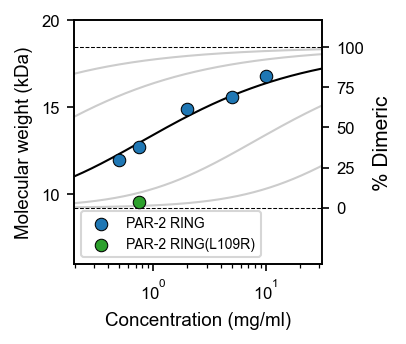

In [5]:
fig = create_figure(
    x_wt=x_wt, y_wt=y_wt, wd=wd, x_l109r=x_l109r, y_l109r=y_l109r, xmin=-0.7, xmax=1.5
)
fig.savefig("Figs/titration.png", dpi=600, transparent=True)
fig.savefig("Figs/titration.pdf", transparent=True)

In [6]:
# SourceData
df_figure = pd.concat(
    [
        pd.DataFrame(
            {"Concentration (mg/ml)": x_wt, "Mw (kDa)": y_wt, "Genotype": "WT"}
        ),
        pd.DataFrame(
            {"Concentration (mg/ml)": x_l109r, "Mw (kDa)": y_l109r, "Genotype": "L109R"}
        ),
    ],
    ignore_index=True,
)

df_figure.to_csv("../../../data/EMBO_source_data/2H.csv", index=False)

### Analysis: Experiment 2

In [7]:
# Import wild type data
df = pd.read_csv("../../../data/20240131_PAR_RING_SECMALLS.csv")
df

x_wt = []
y_wt = []
a = df[["Peak 1 (ug/ml)", "Peak 2 (ug/ml)"]].idxmax(axis=1)
for (_, row), a in zip(
    df.iterrows(), df[["Peak 1 (ug/ml)", "Peak 2 (ug/ml)"]].idxmax(axis=1)
):
    if a == "Peak 1 (ug/ml)":
        # x_wt.append(row['Peak 1 (ug/ml)'] / 1000)
        x_wt.append(row["Concentration"])
        y_wt.append(row["Peak 1 (Mw)"] / 1000)
    elif a == "Peak 2 (ug/ml)":
        # x_wt.append(row['Peak 2 (ug/ml)']/1000)
        x_wt.append(row["Concentration"])
        y_wt.append(row["Peak 2 (Mw)"] / 1000)
    else:
        print("Error")

# Fit model
popt, pcov = curve_fit(
    lambda x, wd: mol_weight(x, wd, mass=9.23474),
    x_wt,
    y_wt,
)
wd = popt[0]
kd = np.exp(-wd)
print(kd)

0.4622749264755219


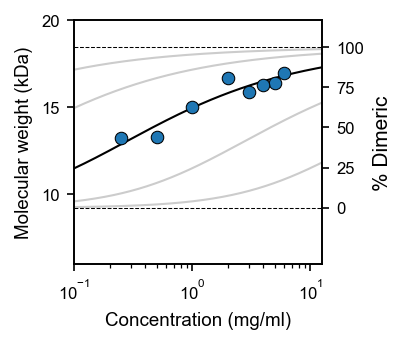

In [8]:
fig = create_figure(x_wt=x_wt, y_wt=y_wt, wd=wd, xmin=-1, xmax=1.1)